In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# I've made the decision to limit my search to the station in Honolulu so I'm not plotting multiple values on the same date.

# Calculate the date 1 year ago from the last data point in the database
YearStart=dt.datetime.date(dt.datetime.fromisoformat(engine.execute("SELECT max(date) FROM measurement WHERE station in (SELECT station FROM station WHERE name like '%HONOLULU%')").fetchall()[0][0]))- dt.timedelta(days=365)
print(f"The date the year of data will start on is {YearStart}.")

# Perform a query to retrieve the date and precipitation scores
# Since the start date is 2014-10-30, we know there isn't a leap day in our year of data.
engine.execute(f"SELECT date, prcp FROM measurement WHERE (date >= '{YearStart}') AND (station in (SELECT station FROM station WHERE name like '%HONOLULU%')) ORDER BY date LIMIT 10").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(f"SELECT date, prcp FROM measurement WHERE (date >= '{YearStart}') AND (station in (SELECT station FROM station WHERE name like '%HONOLULU%')) ORDER BY date", conn)
df.set_index('date', inplace=True)
# Sort the dataframe by date
df.head()

The date the year of data will start on is 2014-10-30.


,prcp
date,
2014-10-30,0.00
2014-10-31,0.00
2014-11-02,0.01
2014-11-03,0.03
2014-11-04,0.00


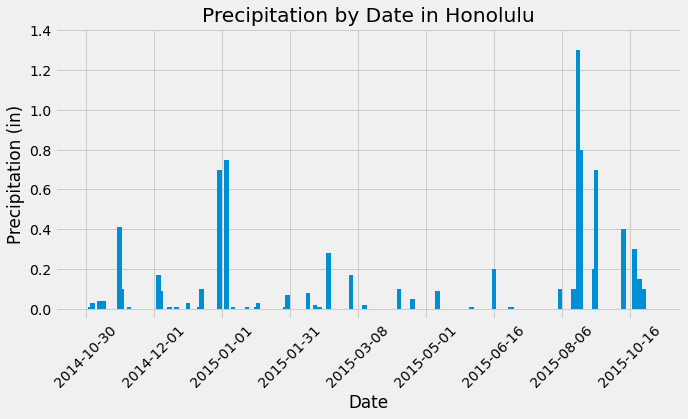

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis=df.index
bars=df.prcp
plt.figure(figsize=(10,5))
plt.bar(x_axis,bars,width=2)
plt.xticks([x for i,x in enumerate(x_axis) if i%30==0],rotation = 45)
plt.ylim(-.05,1.41)
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Precipitation by Date in Honolulu")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,212.00000
mean,0.03717
std,0.14334
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.30000


In [12]:
# Design a query to show the number of stations available in this dataset.
Station_Count=engine.execute("SELECT COUNT(distinct station) FROM measurement").fetchall()[0][0]
print(f"The number of unique stations available in the dataset is {Station_Count}.")

The number of unique stations available in the dataset is 9.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, COUNT(prcp) AS Records_Count, (SELECT name FROM station WHERE measurement.station = station.station) AS station_name FROM measurement GROUP BY station_name ORDER BY Records_Count DESC").fetchall()


[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00513117', 2696, 'KANEOHE 838.1, HI US'),
 ('USC00519397', 2685, 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 2572, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2484, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 1937, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1932, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 683, 'PEARL CITY, HI US'),
 ('USC00518838', 342, 'UPPER WAHIAWA 874.3, HI US')]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
Station_info=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()[0]
print(f"The temp. info for station USC00519281 is the following:\nLow: {Station_info[0]}\nHigh: {Station_info[1]}\nAvg: {round(Station_info[2],2)}")


The temp. info for station USC00519281 is the following:
Low: 54.0
High: 85.0
Avg: 71.66


In [15]:
# Choose the station with the highest number of temperature observations.
engine.execute("SELECT station, COUNT(tobs) AS Records_Count, (SELECT name FROM station WHERE measurement.station = station.station) AS station_name FROM measurement GROUP BY station_name ORDER BY Records_Count DESC").fetchall()


[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00519397', 2724, 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 2709, 'KANEOHE 838.1, HI US'),
 ('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 1372, 'PEARL CITY, HI US'),
 ('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')]

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date 1 year ago from the last data point in the database
YearStart=dt.datetime.date(dt.datetime.fromisoformat(engine.execute("SELECT max(date) FROM measurement WHERE station = 'USC00519281'").fetchall()[0][0]))- dt.timedelta(days=365)
print(f"The date the year of data will start on is {YearStart}.")

# Save the query results as a Pandas DataFrame and set the index to the date column
Temp_df = pd.read_sql(f"SELECT date, tobs as temp FROM measurement WHERE (date >= '{YearStart}') AND (station = 'USC00519281') ORDER BY date", conn)
Temp_df.set_index('date', inplace=True)
# Sort the dataframe by date
Temp_df.head()

The date the year of data will start on is 2016-08-18.


,temp
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


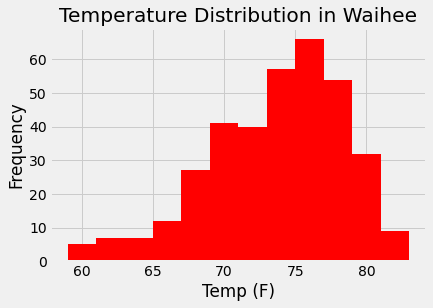

In [17]:
#Plot the histogram
Temp_df["temp"].plot.hist(title="Temperature Distribution in Waihee", color="red",bins=12)
plt.xlabel("Temp (F)")
plt.show()

## Bonus Challenge

## Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in June and December?

In [18]:
#Determine the average temp in June and December across all stations and all years of the data set.
June_Avg=engine.execute("SELECT avg(tobs), count(tobs), (SELECT SUM((tobs-(SELECT AVG(tobs) FROM measurement))*(tobs-(SELECT AVG(tobs) FROM measurement)) ) / (COUNT(tobs)-1)) AS Variance FROM measurement WHERE date LIKE '%-06-%' ORDER BY date").fetchall()[0]
Dec_Avg=engine.execute("SELECT avg(tobs), count(tobs), (SELECT SUM((tobs-(SELECT AVG(tobs) FROM measurement))*(tobs-(SELECT AVG(tobs) FROM measurement)) ) / (COUNT(tobs)-1)) AS Variance FROM measurement WHERE date LIKE '%-12-%' ORDER BY date").fetchall()[0]
print('(average          , count, variance        )')
#To use the independent t-test to compare 2 means using an we need to see if the count in each sample is similar and if the variances are 'close' meaning one isn't more that twice the other. 
print(June_Avg)
print(Dec_Avg)

(average          , count, variance        )
(74.94411764705882, 1700, 14.021092266714305)
(71.04152933421226, 1517, 18.26358709666216)


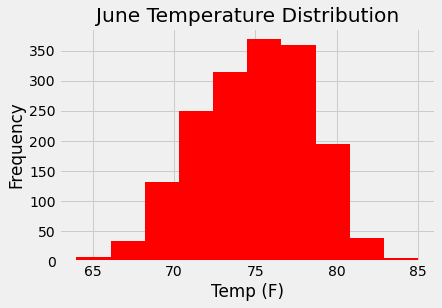

In [19]:
#We need to show that these samples are normally distributed from the histograms below, it is clear that they are.
pd.read_sql("SELECT tobs FROM measurement WHERE date LIKE '%-06-%' ORDER BY date", conn).plot.hist(title="June Temperature Distribution", color="red", legend=None)
plt.xlabel("Temp (F)")
plt.show()

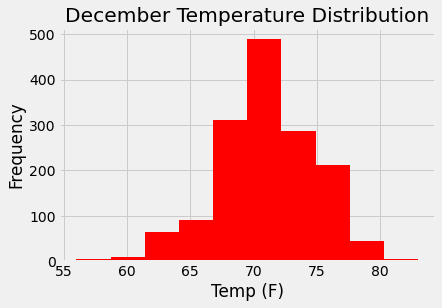

In [20]:
pd.read_sql("SELECT tobs FROM measurement WHERE date LIKE '%-12-%' ORDER BY date", conn).plot.hist(title="December Temperature Distribution", color="red", legend=None)
plt.xlabel("Temp (F)")
plt.show()

In [21]:
June=np.ravel(engine.execute("SELECT tobs FROM measurement WHERE date LIKE '%-06-%' ORDER BY date").fetchall())
December=np.ravel(engine.execute("SELECT tobs FROM measurement WHERE date LIKE '%-12-%' ORDER BY date").fetchall())
print(June,len(June))
print(December,len(December))

[78. 74. 73. ... 75. 76. 75.] 1700
[76. 73. 73. ... 72. 67. 65.] 1517


In [22]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why? - answered above. Also we use an unpaired test becasue the samples are independent of eachother.
st.ttest_ind(June,December)


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

According to the test the means are different and the p-value being so low indicates that with any other sample, this is extremely likely to be the outcome again. 

## Bonus part 2

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def VacEst(VS,VE):
    LY_Vacation_Start=str(int(VS[:4])-1)+VS[4:]
    LY_Vacation_End=str(int(VE[:4])-1)+VE[4:]
    [(tmin,tavg,tmax)]=calc_temps(LY_Vacation_Start, LY_Vacation_End)
    return (tmin,tavg,tmax)

Vacation_Start='2016-04-03'
Vacation_End='2016-04-13'
(tmin,tavg,tmax)=VacEst(Vacation_Start,Vacation_End)

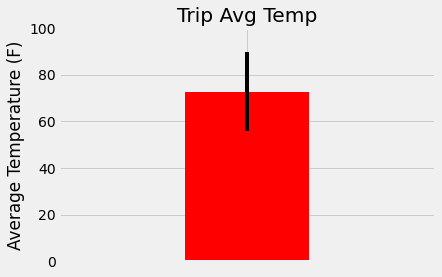

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar([""],[tavg],width=.33, color='red',yerr=tmax-tmin)
plt.ylabel("Average Temperature (F)")
plt.title("Trip Avg Temp")
plt.xlim(-.5,.5)
plt.ylim(0,100)
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
LY_Vacation_Start=str(int(Vacation_Start[:4])-1)+Vacation_Start[4:]
LY_Vacation_End=str(int(Vacation_End[:4])-1)+Vacation_End[4:]
engine.execute(f"SELECT m.date, ROUND(SUM(m.prcp),2) as TotalRainfall, m.station, s.name, s.latitude, s.longitude, s.elevation FROM measurement m INNER JOIN station s ON s.station = m.station WHERE m.date <= '{LY_Vacation_End}' and m.date >= '{LY_Vacation_Start}' GROUP BY m.station ORDER BY TotalRainfall DESC").fetchall()


[('2015-04-04', 1.73, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('2015-04-03', 0.65, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('2015-04-03', 0.4, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('2015-04-03', 0.37, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('2015-04-03', 0.02, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('2015-04-03', 0.01, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('2015-04-03', 0.0, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)]

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
Vacation_Start='2016-04-03'
Vacation_End='2016-04-13'
# Use the start and end date to create a range of dates
dateRange=[]
dateCounter=Vacation_Start
while dateCounter<=Vacation_End:
    dateRange.append(dateCounter[5:])
    if int(dateCounter[-2:])<9:
        dateCounter=dateCounter[:9]+str(int(dateCounter[-1:])+1)
    else:
        dateCounter=dateCounter[:8]+str(int(dateCounter[-2:])+1)

# Stip off the year and save a list of %m-%d strings
print(dateRange)
# Loop through the list of %m-%d strings and calculate the normals for each date
TripNormals=[]
for date in dateRange:
    TripNormals.append(daily_normals(date)[0])

print (TripNormals)

['04-03', '04-04', '04-05', '04-06', '04-07', '04-08', '04-09', '04-10', '04-11', '04-12', '04-13']
[(55.0, 72.2280701754386, 78.0), (58.0, 72.01639344262296, 78.0), (61.0, 72.28813559322033, 80.0), (67.0, 71.57142857142857, 77.0), (63.0, 71.10526315789474, 78.0), (66.0, 72.10526315789474, 77.0), (62.0, 71.6140350877193, 78.0), (64.0, 71.40350877192982, 79.0), (65.0, 72.49180327868852, 82.0), (65.0, 72.22413793103448, 80.0), (64.0, 71.52542372881356, 79.0)]


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
TripMin=[x[0] for x in TripNormals]
TripAvg=[round(x[1],2) for x in TripNormals]
TripMax=[x[2] for x in TripNormals]
Trip_df=pd.DataFrame({
    "Date": dateRange,
    "Min": TripMin,
    "Avg": TripAvg,
    "Max": TripMax
})
Trip_df.set_index('Date', inplace=True)
Trip_df.head()

,Min,Avg,Max
Date,,,
04-03,55.0,72.23,78.0
04-04,58.0,72.02,78.0
04-05,61.0,72.29,80.0
04-06,67.0,71.57,77.0
04-07,63.0,71.11,78.0


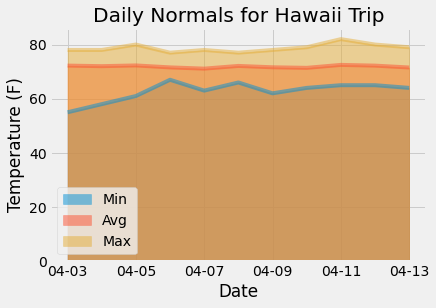

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
Trip_df.plot.area(stacked=False)
plt.ylabel("Temperature (F)")
plt.title("Daily Normals for Hawaii Trip")
plt.show()
#Although this is what was asked, using an area chart instead of a line chart here is a mistake. There is no value added by filling in the area.